In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from PIL import Image
import os
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [28]:
! pip3 install guppy3

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 649 kB 1.5 MB/s            


In [29]:
%%writefile shifting.py
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt
from PIL import Image
import time
import sys
import os


def main(a_path, h):
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    img = np.array(Image.open(a_path), dtype=np.uint8)
    img_h = img.shape[0]
    img_w = img.shape[1]
    roll  = img.shape[2]
        
    # Data preparation
    if rank == 0:
        # count the size of the array of each process
        q = img_w // size
        r = img_w % size

        sizes = [q + 1 if i < r else q for i in range(size)]
        sizes = np.array(sizes, dtype=np.int32)
        
        # the starting index of each process
        shifts = [sum(sizes[:i]) for i in range(size)]
        shifts = np.array(shifts, dtype=np.int32)
    else:
        sizes = np.zeros(size, dtype=np.int32)
        shifts = np.zeros(size, dtype=np.int32)

    # Broadcasting
    comm.Bcast(sizes)
    comm.Bcast(shifts)
    
    # Initial shifts
    img = np.roll(img, roll * shifts[rank], axis=1)
    for shift in range(shifts[rank], shifts[rank] + sizes[rank]):
        Image.fromarray(img).save(f"../imgs/task8/img_{shift:09d}.png")
        img = np.roll(img, roll, axis=1)

    # Memory usage
    if h:
        mem_used = h.heap().size
        mem_usage = comm.reduce(mem_used, op=MPI.SUM)
    else:
        mem_usage = None
        comm.Barrier()

    if rank == 0:
        return img_w, mem_usage
    else:
        return None, mem_usage

if __name__ == "__main__":
    path = sys.argv[1]
    
    # Memory check
    h = None
    arg = None
    if len(sys.argv) == 3:
        arg = sys.argv[2]
        if arg == "memory":
            from guppy import hpy
            h = hpy()

    MPI.COMM_WORLD.Barrier()

    start = time.time()
    n, mem = main(path, h)
    elapsed = time.time() - start

    if n is not None:
        if arg == "save":
            images = []
            for i in range(n):
                fname = f"../imgs/task8/img_{i:09d}.png"
                images.append(Image.open(fname))
            images[0].save('./shifted.gif', save_all=True, append_images=images[1:], loop=0, duration=50)
            print(f"Elapsed time: {elapsed}")
        elif arg == "memory":
            print(mem)
        else:
            print(elapsed)
        for i in range(n):
            fname = f"../imgs/task8/img_{i:09d}.png"
            os.remove(fname)

Overwriting shifting.py


In [3]:
! mpiexec -n 4 python3 shifting.py chase.png save

Elapsed time: 4.288843393325806


![SegmentLocal](shifted.gif "segment")

In [19]:
cores = os.cpu_count()
runs = 5
times = []
for i in range(1, cores + 1):
    ts = []
    for _ in range(runs):
        t = ! mpiexec -n $i python3 shifting.py chase.png time
        ts.append(float(t[0]))
    times.append(np.mean(ts))
    print(f"# of processors: {i}: time: {times[i - 1]}")

# of processors: 1: time: 16.565593004226685
# of processors: 2: time: 8.492255449295044
# of processors: 3: time: 5.5626444816589355
# of processors: 4: time: 4.2468788623809814
# of processors: 5: time: 3.453662633895874
# of processors: 6: time: 2.942197561264038
# of processors: 7: time: 2.541501045227051
# of processors: 8: time: 2.82216477394104
# of processors: 9: time: 2.393782615661621
# of processors: 10: time: 2.417018413543701
# of processors: 11: time: 2.2241976261138916
# of processors: 12: time: 2.0892434120178223
# of processors: 13: time: 1.8761661052703857
# of processors: 14: time: 1.7616643905639648
# of processors: 15: time: 1.656693696975708
# of processors: 16: time: 1.6106646060943604


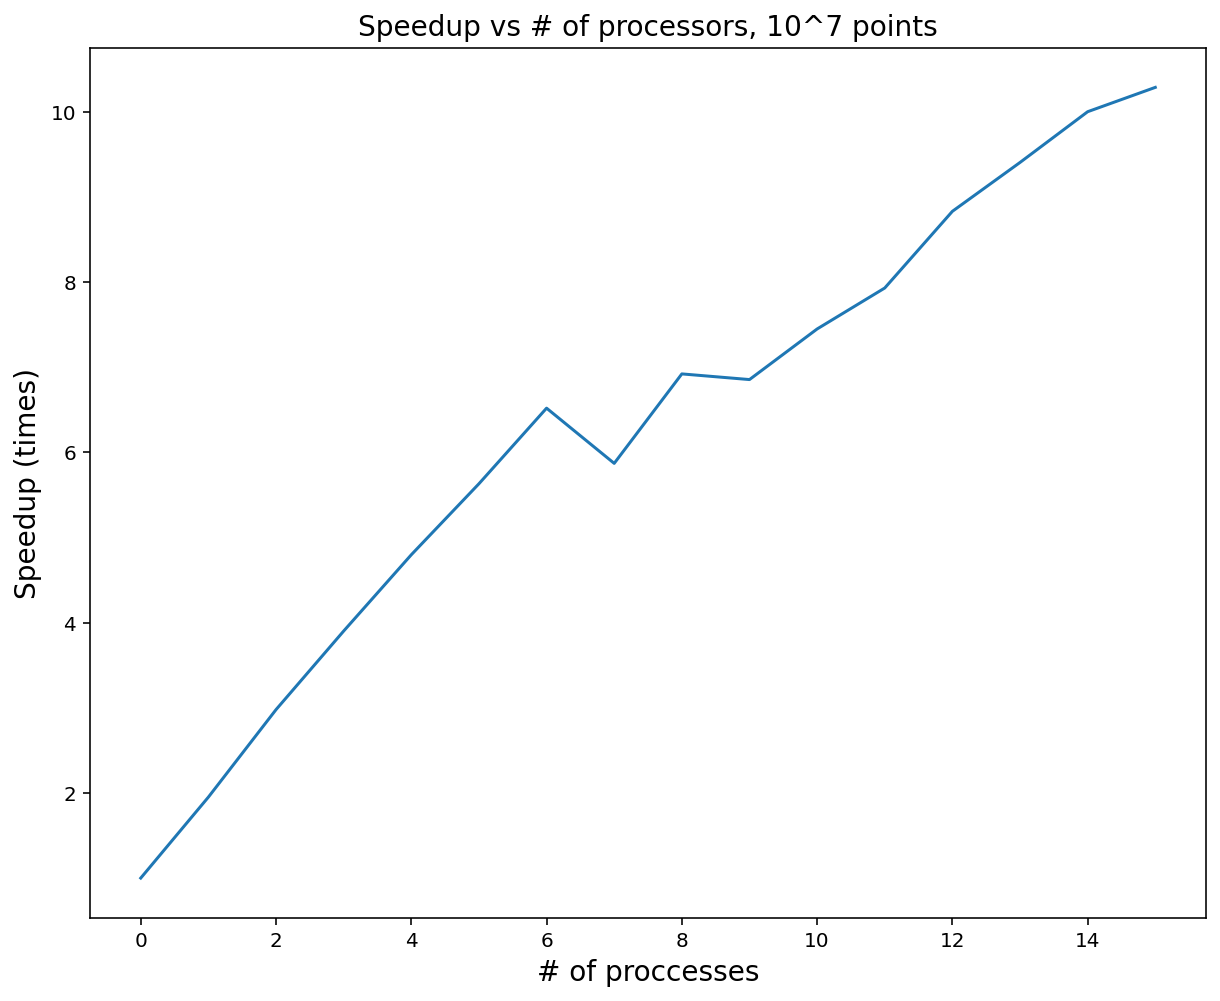

In [20]:
times = np.array(times)
speedup = times[0] / times
plt.figure(figsize=(10,8))
plt.plot(speedup)
plt.title("Speedup vs # of processors", fontsize=14)
plt.xlabel("# of proccesses", fontsize=14)
plt.ylabel("Speedup (times)", fontsize=14)
plt.show()

Almost linear, which is very cool!

In [ ]:
cores = os.cpu_count()
runs = 1
memory = []
for i in range(1, cores + 1):
    ms = []
    for _ in range(runs):
        m = ! mpiexec -n $i python3 shifting.py chase.png memory
        ms.append((float(m[0]) / (2**20))) # in MBs
    memory.append(np.mean(ms))
    print(f"# of processors: {i}: memory: {memory[i - 1]}")

# of processors: 1: memory: 48.149062156677246
# of processors: 2: memory: 96.29730606079102
# of processors: 3: memory: 144.44544410705566
# of processors: 4: memory: 192.59371948242188
# of processors: 5: memory: 240.7415132522583
# of processors: 6: memory: 288.88975524902344
# of processors: 7: memory: 337.037917137146
# of processors: 8: memory: 385.1864700317383
# of processors: 9: memory: 433.33438205718994


In [ ]:
memory = np.array(memory)
plt.figure(figsize=(10,8))
plt.plot(speedup)
plt.title("Memory consumption vs # of processors", fontsize=14)
plt.xlabel("# of proccesses", fontsize=14)
plt.ylabel("Memory, MB", fontsize=14)
plt.show()

Along with speedup memory consumption rises almost linear, obviously.